In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

/home/ubuntu/.local/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
# from pts.model.tempflow import TempFlowEstimator
from pts.model.time_grad import TimeGradEstimator
# from pts.model.transformer_tempflow import TransformerTempFlowEstimator
# from pts import Trainer
from pytorch_lightning import Trainer

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(


In [4]:
from diffusers import (
    PNDMScheduler,
    DDIMScheduler,
    DPMSolverMultistepScheduler,
    KDPM2DiscreteScheduler,
    DEISMultistepScheduler,
)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

In [7]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_wit

In [8]:
# exchange_rate_nips, electricity_nips, traffic_nips, solar_nips, wiki-rolling_nips, ## taxi_30min is buggy still
dataset_electricity = get_dataset("electricity_nips", regenerate=False)
dataset_exchange_rate = get_dataset("exchange_rate_nips", regenerate=False)
dataset_traffic = get_dataset("traffic_nips", regenerate=False)
dataset_solar = get_dataset("solar_nips", regenerate=False)

In [9]:
dataset_electricity.metadata
dataset_exchange_rate.metadata
dataset_traffic.metadata
dataset_solar.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [10]:
train_grouper_electricity = MultivariateGrouper(max_target_dim=min(2000, int(dataset_electricity.metadata.feat_static_cat[0].cardinality)))

test_grouper_electricity = MultivariateGrouper(num_test_dates=int(len(dataset_electricity.test)/len(dataset_electricity.train)), 
                                   max_target_dim=min(2000, int(dataset_electricity.metadata.feat_static_cat[0].cardinality)))

train_grouper_exchange_rate = MultivariateGrouper(max_target_dim=min(2000, int(dataset_exchange_rate.metadata.feat_static_cat[0].cardinality)))

test_grouper_exchange_rate = MultivariateGrouper(num_test_dates=int(len(dataset_exchange_rate.test)/len(dataset_exchange_rate.train)), 
                                   max_target_dim=min(2000, int(dataset_exchange_rate.metadata.feat_static_cat[0].cardinality)))

train_grouper_traffic = MultivariateGrouper(max_target_dim=min(2000, int(dataset_traffic.metadata.feat_static_cat[0].cardinality)))

test_grouper_traffic = MultivariateGrouper(num_test_dates=int(len(dataset_traffic.test)/len(dataset_traffic.train)), 
                                   max_target_dim=min(2000, int(dataset_traffic.metadata.feat_static_cat[0].cardinality)))

train_grouper_solar = MultivariateGrouper(max_target_dim=min(2000, int(dataset_solar.metadata.feat_static_cat[0].cardinality)))

test_grouper_solar = MultivariateGrouper(num_test_dates=int(len(dataset_solar.test)/len(dataset_solar.train)), 
                                   max_target_dim=min(2000, int(dataset_solar.metadata.feat_static_cat[0].cardinality)))



In [11]:
dataset_train_electricity = train_grouper_electricity(dataset_electricity.train)
dataset_test_electricity = test_grouper_electricity(dataset_electricity.test)

dataset_train_exchange_rate = train_grouper_exchange_rate(dataset_exchange_rate.train)
dataset_test_exchange_rate = test_grouper_exchange_rate(dataset_exchange_rate.test)

dataset_train_traffic = train_grouper_traffic(dataset_traffic.train)
dataset_test_traffic = test_grouper_traffic(dataset_traffic.test)

dataset_train_solar = train_grouper_solar(dataset_solar.train)
dataset_test_solar = test_grouper_solar(dataset_solar.test)

In [12]:
scheduler = DEISMultistepScheduler(
    num_train_timesteps=150,
    beta_end=0.1,
)

In [13]:
estimator_electricity = TimeGradEstimator(
    input_size=int(dataset_electricity.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=149,
    prediction_length=dataset_electricity.metadata.prediction_length,
    context_length=dataset_electricity.metadata.prediction_length * 3,
    freq=dataset_electricity.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=200, accelerator="gpu", devices="1"),
)

estimator_exchange_rate = TimeGradEstimator(
    input_size=int(dataset_exchange_rate.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=149,
    prediction_length=dataset_exchange_rate.metadata.prediction_length,
    context_length=dataset_exchange_rate.metadata.prediction_length * 3,
    freq=dataset_exchange_rate.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=200, accelerator="gpu", devices="1"),
)

estimator_traffic = TimeGradEstimator(
    input_size=int(dataset_traffic.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=149,
    prediction_length=dataset_traffic.metadata.prediction_length,
    context_length=dataset_traffic.metadata.prediction_length * 3,
    freq=dataset_traffic.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=200, accelerator="gpu", devices="1"),
)

estimator_solar = TimeGradEstimator(
    input_size=int(dataset_solar.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=149,
    prediction_length=dataset_solar.metadata.prediction_length,
    context_length=dataset_solar.metadata.prediction_length * 3,
    freq=dataset_solar.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=200, accelerator="gpu", devices="1"),
)

In [14]:
predictor_electricity = estimator_electricity.train(dataset_train_electricity, num_workers=8)

predictor_exchange_rate = estimator_exchange_rate.train(dataset_train_exchange_rate, num_workers=8)

predictor_traffic = estimator_traffic.train(dataset_train_traffic, num_workers=8)

predictor_solar = estimator_solar.train(dataset_train_solar, num_workers=8)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ubuntu/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-04-29 01:58:18.905458: I tensorflow/core/util/port.cc:110] oneDNN custom operations are o

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 0.34091 (best 0.34091), saving model to '/home/ubuntu/timegrad-s4/lightning_logs/version_4/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.09123 (best 0.09123), saving model to '/home/ubuntu/timegrad-s4/lightning_logs/version_4/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 0.06064 (best 0.06064), saving model to '/home/ubuntu/timegrad-s4/lightning_logs/version_4/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 0.05209 (best 0.05209), saving model to '/home/ubuntu/timegrad-s4/lightning_logs/version_4/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 0.04633 (best 0.04633), saving model to '/home/ubuntu/timegrad-s4/lightning_logs/version_4/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 0.04411 (best 0.04411), saving model to '/hom

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 0.31648 (best 0.31648), saving model to '/home/ubuntu/timegrad-s4/lightning_logs/version_5/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.05481 (best 0.05481), saving model to '/home/ubuntu/timegrad-s4/lightning_logs/version_5/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 0.03038 (best 0.03038), saving model to '/home/ubuntu/timegrad-s4/lightning_logs/version_5/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 0.01860 (best 0.01860), saving model to '/home/ubuntu/timegrad-s4/lightning_logs/version_5/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 0.01454 (best 0.01454), saving model to '/home/ubuntu/timegrad-s4/lightning_logs/version_5/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 0.01211 (best 0.01211), saving model to '/hom

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 0.34716 (best 0.34716), saving model to '/home/ubuntu/timegrad-s4/lightning_logs/version_6/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.13447 (best 0.13447), saving model to '/home/ubuntu/timegrad-s4/lightning_logs/version_6/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 0.08113 (best 0.08113), saving model to '/home/ubuntu/timegrad-s4/lightning_logs/version_6/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 0.07346 (best 0.07346), saving model to '/home/ubuntu/timegrad-s4/lightning_logs/version_6/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 0.06865 (best 0.06865), saving model to '/home/ubuntu/timegrad-s4/lightning_logs/version_6/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 0.06668 (best 0.06668), saving model to '/hom

In [15]:
forecast_it_electricity, ts_it_electricity = make_evaluation_predictions(dataset=dataset_test_electricity,
                                                 predictor=predictor_electricity,
                                                 num_samples=100)

forecast_it_exchange_rate, ts_it_exchange_rate = make_evaluation_predictions(dataset=dataset_test_exchange_rate,
                                                 predictor=predictor_exchange_rate,
                                                 num_samples=100)

forecast_it_traffic, ts_it_traffic = make_evaluation_predictions(dataset=dataset_test_traffic,
                                                 predictor=predictor_traffic,
                                                 num_samples=100)

forecast_it_solar, ts_it_solar = make_evaluation_predictions(dataset=dataset_test_solar,
                                                 predictor=predictor_solar,
                                                 num_samples=100)

In [16]:
forecasts_electricity = list(forecast_it_electricity)
targets_electricity = list(ts_it_electricity)

forecasts_exchange_rate = list(forecast_it_exchange_rate)
targets_exchange_rate = list(ts_it_exchange_rate)

forecasts_traffic = list(forecast_it_traffic)
targets_traffic = list(ts_it_traffic)

forecasts_solar = list(forecast_it_solar)
targets_solar = list(ts_it_solar)

Electricity


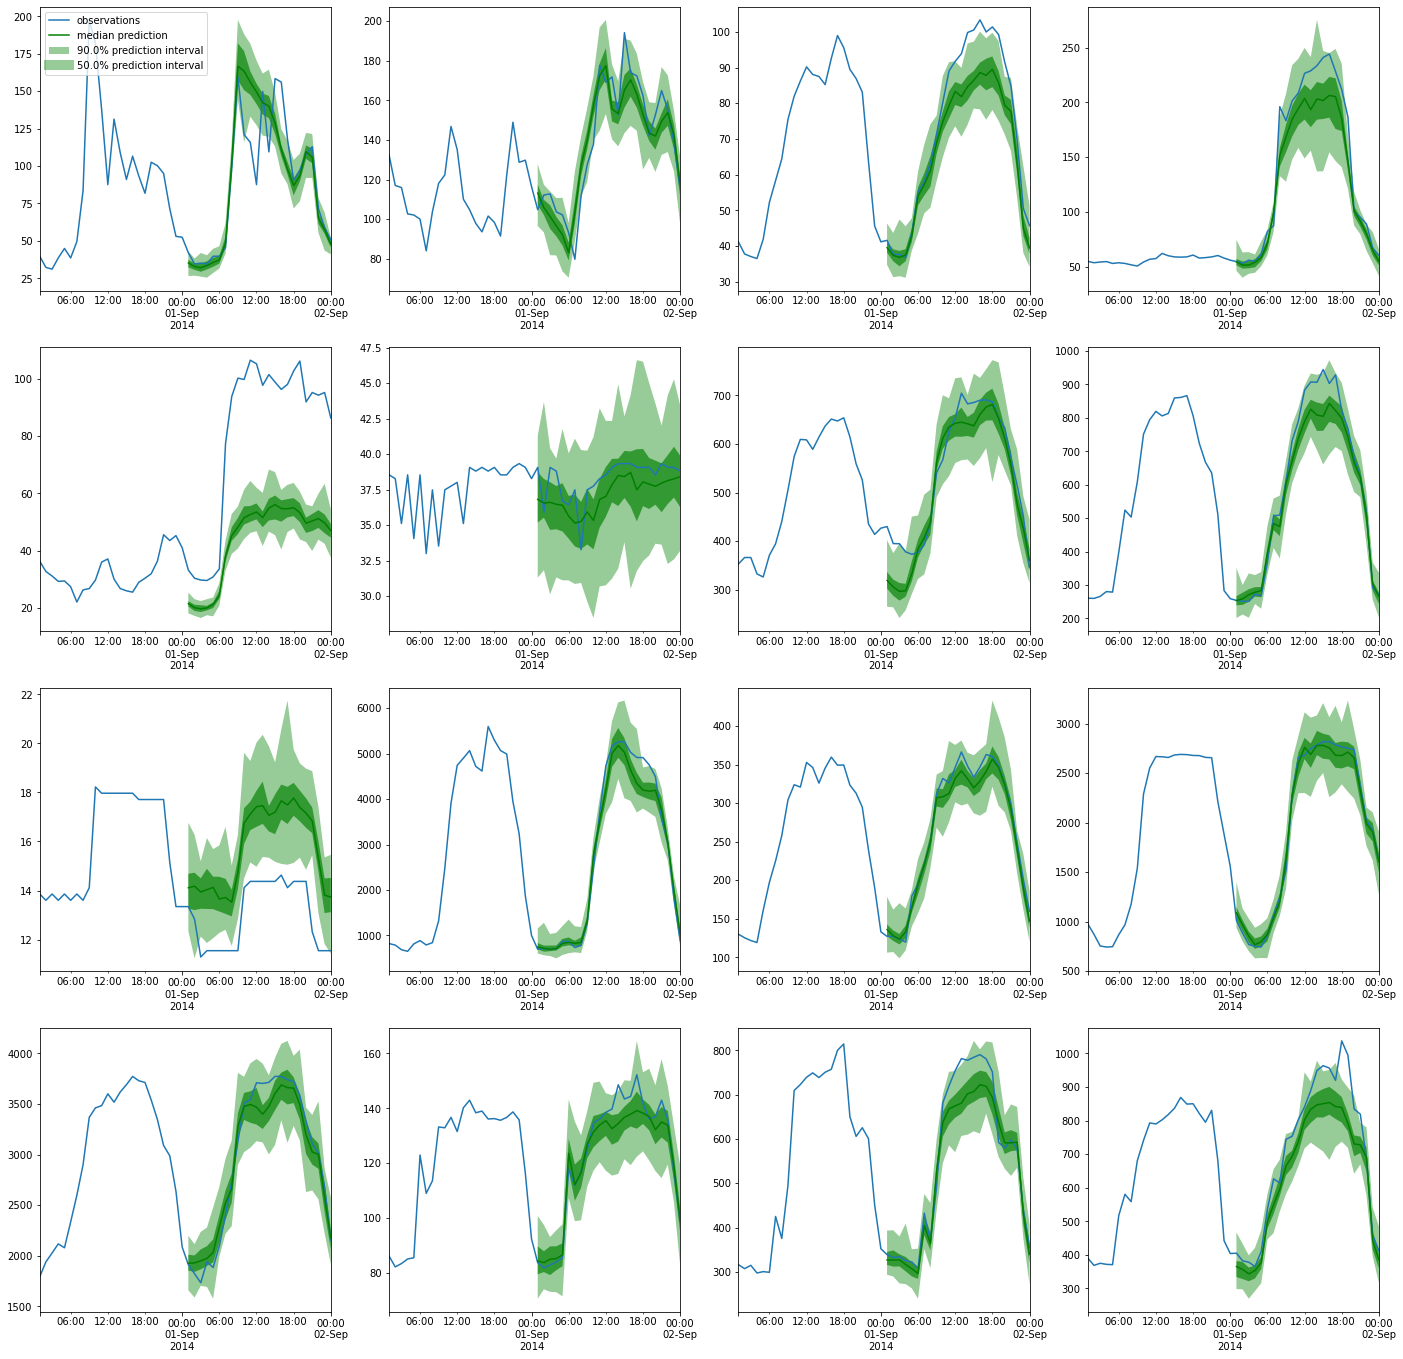


Exchange Rate


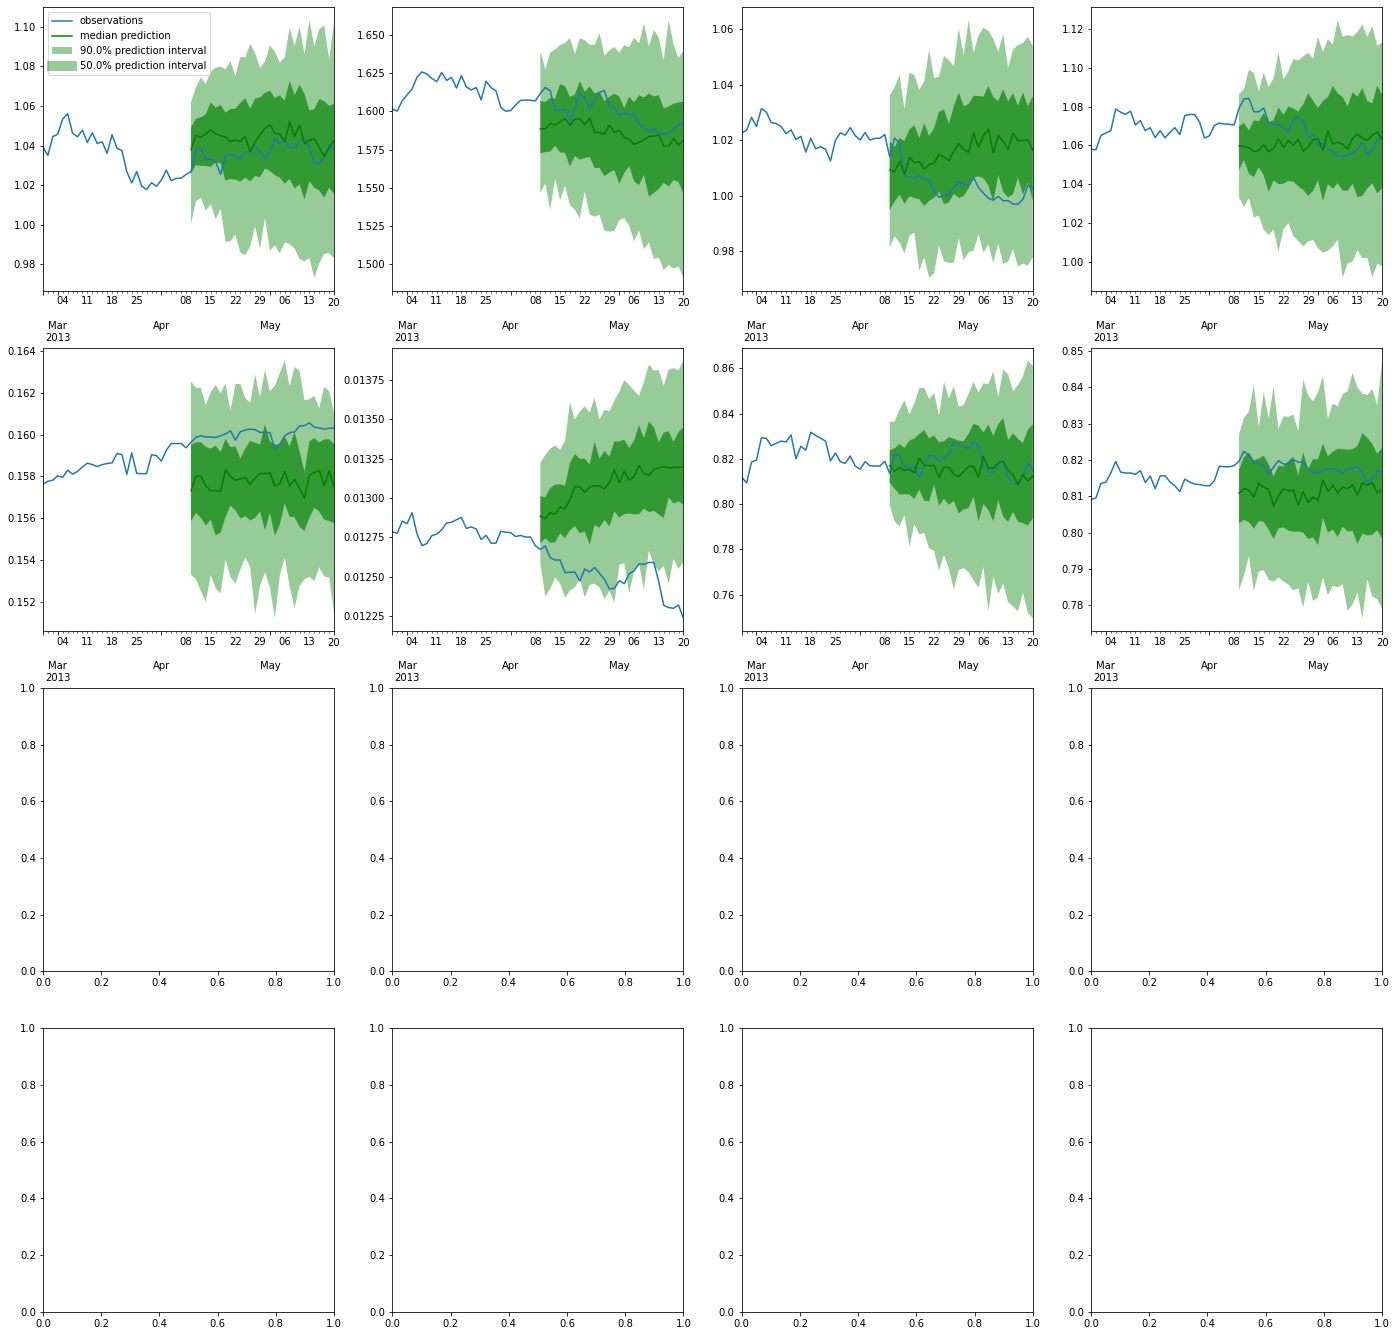


Traffic


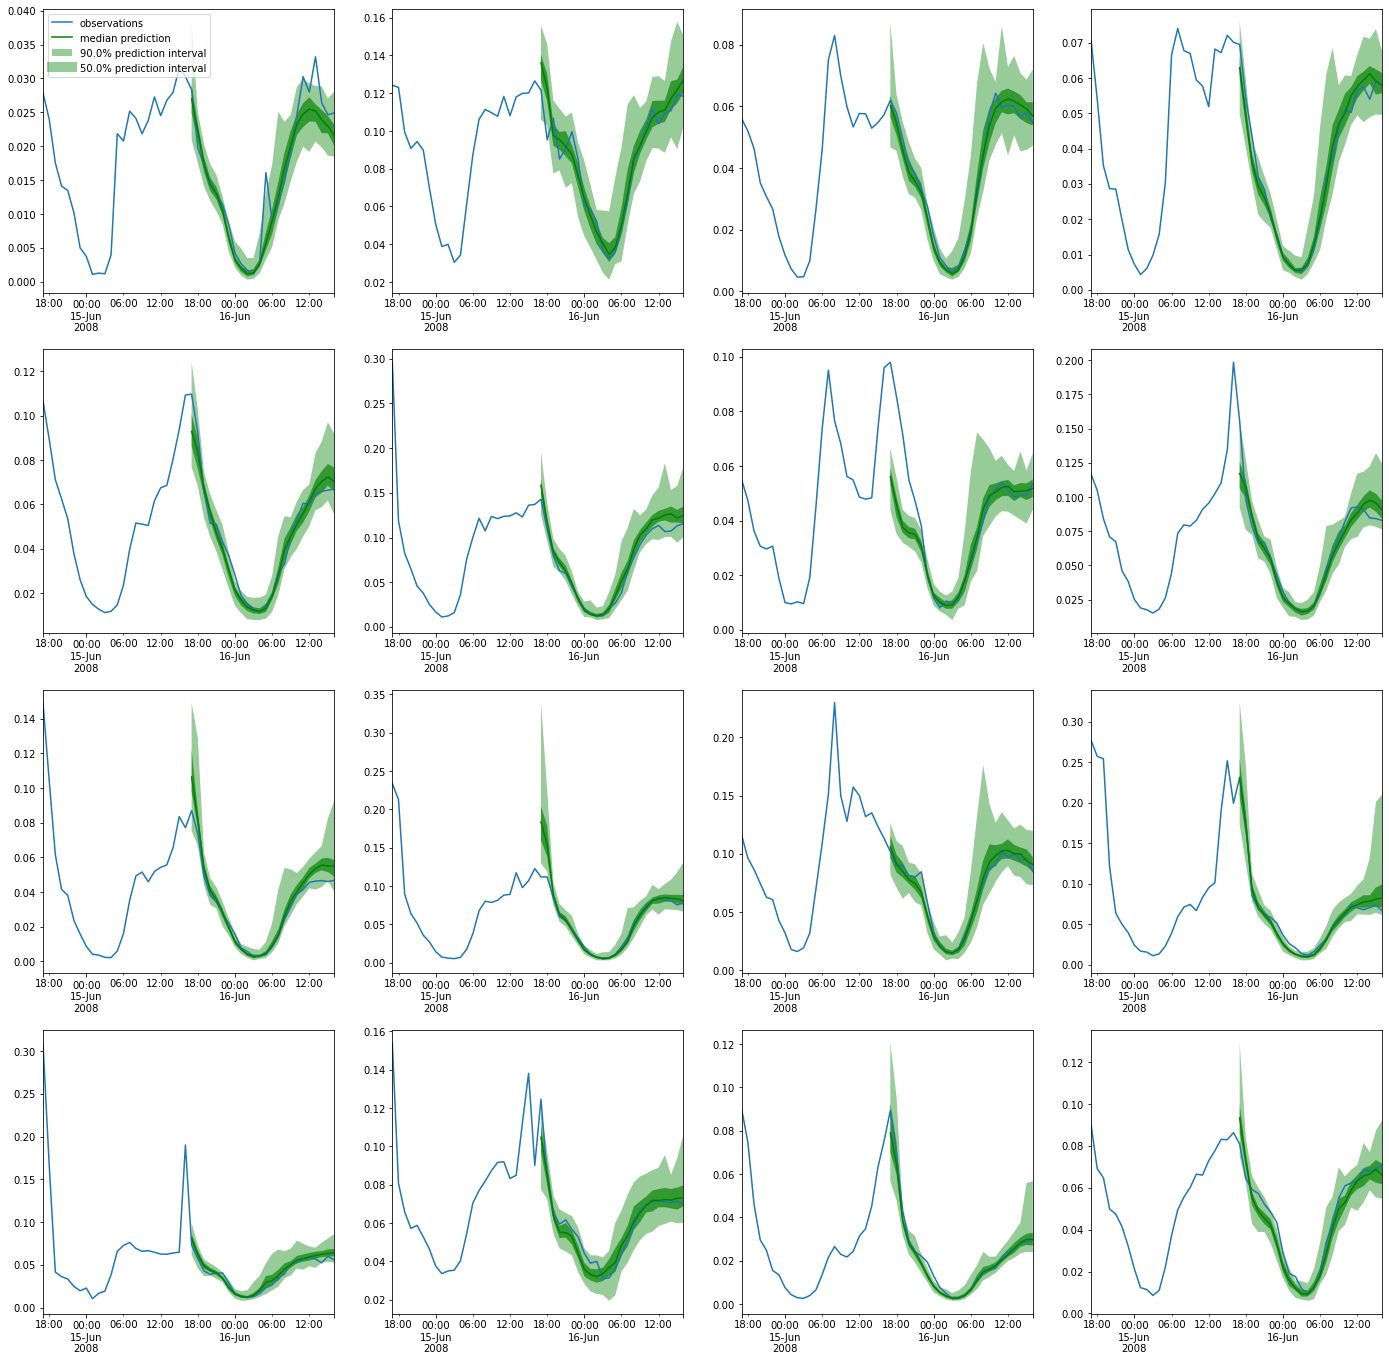


Solar


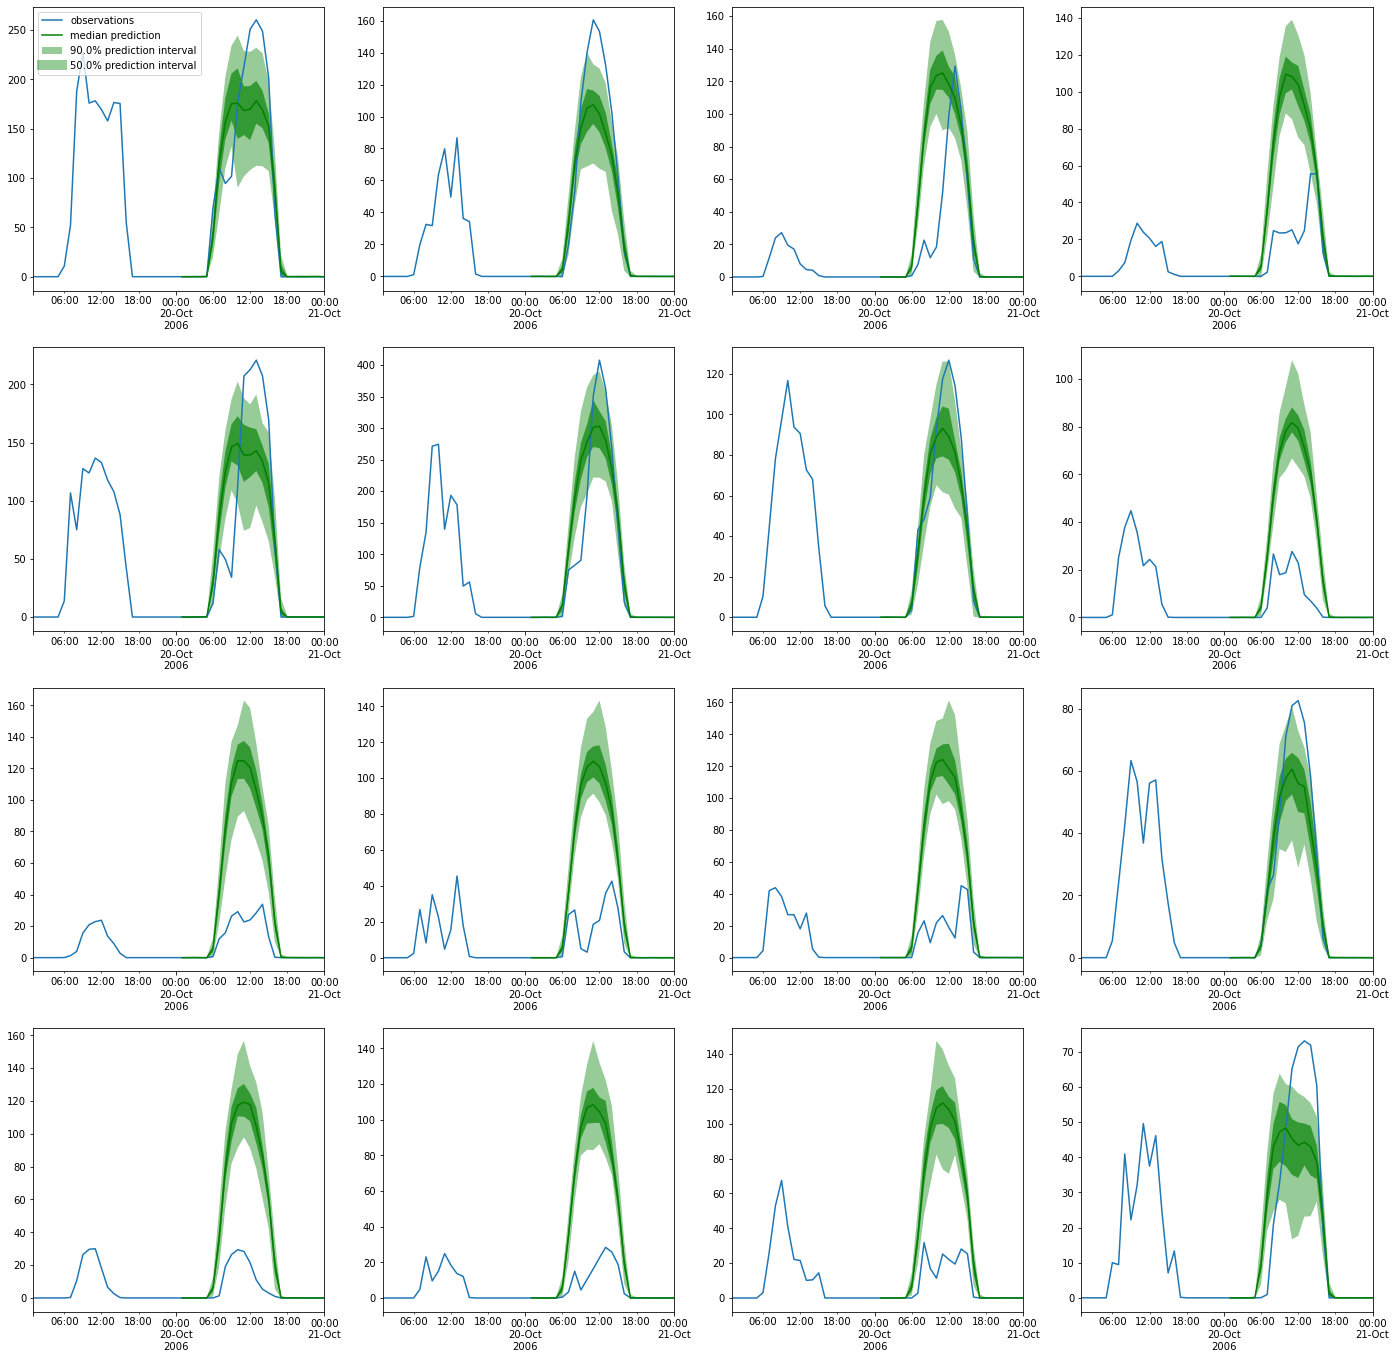

In [17]:
print("Electricity")

plot(
    target=targets_electricity[0],
    forecast=forecasts_electricity[0],
    prediction_length=dataset_electricity.metadata.prediction_length,
)
plt.show()

print()
print("Exchange Rate")
plot(
    target=targets_exchange_rate[0],
    forecast=forecasts_exchange_rate[0],
    prediction_length=dataset_exchange_rate.metadata.prediction_length,
)
plt.show()

print()
print("Traffic")
plot(
    target=targets_traffic[0],
    forecast=forecasts_traffic[0],
    prediction_length=dataset_traffic.metadata.prediction_length,
)
plt.show()

print()
print("Solar")
plot(
    target=targets_solar[0],
    forecast=forecasts_solar[0],
    prediction_length=dataset_solar.metadata.prediction_length,
)
plt.show()




In [18]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [ ]:
agg_metric_electricity, item_metrics_electricity = evaluator(targets_electricity, forecasts_electricity, num_series=len(dataset_test_electricity))
agg_metric_exchange_rate, item_metrics_exchange_rate = evaluator(targets_exchange_rate, forecasts_exchange_rate, num_series=len(dataset_test_exchange_rate))
agg_metric_traffic, item_metrics_traffic = evaluator(targets_traffic, forecasts_traffic, num_series=len(dataset_test_traffic))
agg_metric_solar, item_metrics_solar = evaluator(targets_solar, forecasts_solar, num_series=len(dataset_test_solar))

Running evaluation: 7it [00:00, 136.95it/s]
Running evaluation: 7it [00:00, 146.36it/s]
Running evaluation: 7it [00:00, 148.83it/s]
Running evaluation: 7it [00:00, 148.71it/s]
Running evaluation: 7it [00:00, 148.43it/s]
Running evaluation: 7it [00:00, 150.16it/s]
Running evaluation: 7it [00:00, 150.69it/s]
Running evaluation: 7it [00:00, 149.08it/s]
Running evaluation: 7it [00:00, 148.89it/s]
Running evaluation: 7it [00:00, 150.98it/s]
Running evaluation: 7it [00:00, 150.54it/s]
Running evaluation: 7it [00:00, 151.81it/s]
Running evaluation: 7it [00:00, 150.33it/s]
Running evaluation: 7it [00:00, 149.21it/s]
Running evaluation: 7it [00:00, 150.16it/s]
Running evaluation: 7it [00:00, 151.74it/s]
Running evaluation: 7it [00:00, 147.32it/s]
Running evaluation: 7it [00:00, 150.68it/s]
Running evaluation: 7it [00:00, 149.38it/s]
Running evaluation: 7it [00:00, 150.46it/s]
Running evaluation: 7it [00:00, 152.59it/s]
Running evaluation: 7it [00:00, 151.23it/s]
Running evaluation: 7it [00:00, 

In [ ]:
print("Electricity Results")
print("CRPS:", agg_metric_electricity["mean_wQuantileLoss"])
print("ND:", agg_metric_electricity["ND"])
print("NRMSE:", agg_metric_electricity["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric_electricity["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric_electricity["m_sum_ND"])
print("NRMSE-Sum:", agg_metric_electricity["m_sum_NRMSE"])

print()
print()

print("Exchange Rate Results")
print("CRPS:", agg_metric_exchange_rate["mean_wQuantileLoss"])
print("ND:", agg_metric_exchange_rate["ND"])
print("NRMSE:", agg_metric_exchange_rate["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric_exchange_rate["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric_exchange_rate["m_sum_ND"])
print("NRMSE-Sum:", agg_metric_exchange_rate["m_sum_NRMSE"])

print()
print()

print("Traffic Results")
print("CRPS:", agg_metric_traffic["mean_wQuantileLoss"])
print("ND:", agg_metric_traffic["ND"])
print("NRMSE:", agg_metric_traffic["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric_traffic["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric_traffic["m_sum_ND"])
print("NRMSE-Sum:", agg_metric_traffic["m_sum_NRMSE"])

print()
print()

print("Solar Results")
print("CRPS:", agg_metric_solar["mean_wQuantileLoss"])
print("ND:", agg_metric_solar["ND"])
print("NRMSE:", agg_metric_solar["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric_solar["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric_solar["m_sum_ND"])
print("NRMSE-Sum:", agg_metric_solar["m_sum_NRMSE"])

Electricity Results
CRPS: 0.0518609846318702
ND: 0.06525931482304119
NRMSE: 0.5928885558065451

CRPS-Sum: 0.020338429218880915
ND-Sum: 0.02689957510454694
NRMSE-Sum: 0.04123773017275373


Exchange Rate Results
CRPS: 0.013291050955609788
ND: 0.017449641242383976
NRMSE: 0.02832499460763059

CRPS-Sum: 0.008063499687095181
ND-Sum: 0.010504010405867546
NRMSE-Sum: 0.01396270861975961


Traffic Results
CRPS: 0.11100468319030234
ND: 0.1355079181144542
NRMSE: 0.39786549012204747

CRPS-Sum: 0.046552137974508294
ND-Sum: 0.05800110652523199
NRMSE-Sum: 0.08663816314651307


Solar Results
CRPS: 0.41693250828874184
ND: 0.5111539118013053
NRMSE: 1.0141936787252892

CRPS-Sum: 0.3849916591762514
ND-Sum: 0.44230794081020525
NRMSE-Sum: 0.7967206890483889
